In [121]:
import numpy as np
import matplotlib.pyplot as plt
import random

R_t=  43.30127018922193
[  0.           0.25025025   0.5005005    0.75075075   1.001001
   1.25125125   1.5015015    1.75175175   2.002002     2.25225225
   2.5025025    2.75275275   3.003003     3.25325325   3.5035035
   3.75375375   4.004004     4.25425425   4.5045045    4.75475475
   5.00500501   5.25525526   5.50550551   5.75575576   6.00600601
   6.25625626   6.50650651   6.75675676   7.00700701   7.25725726
   7.50750751   7.75775776   8.00800801   8.25825826   8.50850851
   8.75875876   9.00900901   9.25925926   9.50950951   9.75975976
  10.01001001  10.26026026  10.51051051  10.76076076  11.01101101
  11.26126126  11.51151151  11.76176176  12.01201201  12.26226226
  12.51251251  12.76276276  13.01301301  13.26326326  13.51351351
  13.76376376  14.01401401  14.26426426  14.51451451  14.76476476
  15.01501502  15.26526527  15.51551552  15.76576577  16.01601602
  16.26626627  16.51651652  16.76676677  17.01701702  17.26726727
  17.51751752  17.76776777  18.01801802  18.26826827  1

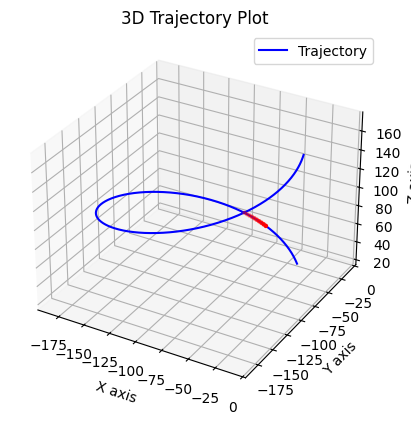

In [ ]:
t = np.linspace(1, 2*np.pi/w, 1000)
s = np.linspace(0, 500, 1000)


# Define the trajectory
# Here we use a simple helical trajectory for demonstration
# You can modify this to any trajectory you want
# x = np.sin(t), y = np.cos(t), z = pz * t
#Detector_radius = 1000
#rho = 100
#v_t=200
#phi = 1
#xc = 50
#yc = 50
#pz=1

d0 = 50
#y0 = 50
B= 2.0 # Magnetic field in Tesla
R_t = 100 # R_t = pT/0.3B = scaled pt


phi0 = np.pi/4
z0 = 25
theta = np.pi/3 # # theta = arctan(pz/pT) = constant angle
qop =1/100
h= np.sign(qop)
R_t = np.sin(theta)/(B*qop) # R_t = pT/0.3B = scaled pt
print("R_t= ", R_t)


class helix:
    def __init__(self, d0, phi0, z0, theta, qop,B):
        self.d0 = d0
        self.R_t = np.sin(theta)/(B*qop)
        self.qop = qop
        self.phi0 = phi0
        self.z0 = z0
        self.theta = theta
        self.h = h
        self.B = B

    def get_coordinates(self, s):
        x = self.d0 * -np.sin(self.phi0) + np.sin(theta)/(qop) * (np.cos(self.phi0 + self.qop * s*B / np.sin(self.theta)) - np.cos(self.phi0))
        y = self.d0 * -np.sin(self.phi0) + np.sin(theta)/(qop) * (np.sin(self.phi0 + self.qop* s*B / np.sin(self.theta)) - np.sin(self.phi0))
        z = self.z0 + s / np.tan(self.theta)
        return x, y, z
    
    





track = helix(d0, phi0, z0, theta,qop,B)
s = np.linspace(0, 250, 1000)
#print(s)

# Plot the trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(track.get_coordinates(s)[0],track.get_coordinates(s)[1], track.get_coordinates(s)[2], label='Trajectory', color='blue')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Trajectory Plot')
ax.legend()


hitlist = np.array([s[i] for i in range(100,150,5)])
#print(hitlist)
print(track.get_coordinates(hitlist))

hitx,hity,hitz = track.get_coordinates(hitlist)
hit_coordinates = np.array([hitx, hity, hitz]).T

centreline=np.array([np.zeros(1000),np.zeros(1000),np.linspace(0,5,1000)])
# Plot the hits
print(centreline)
#ax.plot(centreline[0], centreline[1], centreline[2], color='blue', label='Centreline')
#ax.plot(centreline)
ax.scatter(hitx,hity,hitz, color='red', s=5)



In [185]:
def estimate_initial_momentum(hits, B=2.0, charge=1):
    r1, r2, r3 = hits[:3]
    direction = r3 - r1
    direction /= np.linalg.norm(direction)

    # Crude estimate of radius (use proper circle fit for accuracy)
    R = np.linalg.norm(r2[:2] - r1[:2]) / 2

    pt = 0.3 * charge * B * R  # GeV
    momentum = pt * direction
    return momentum

estimate_initial_momentum(hit_coordinates, B=2.0, charge=1)

array([-0.70979566,  0.12811544,  0.2082403 ])

[-78.75377707 -78.76320803 -78.77258683 ... -79.04964372 -79.04891425
 -79.04792987] [-11.84721688 -11.84538459 -11.84330173 ... -11.46972903 -11.46014947
 -11.45059273] [39.44820493 39.45097879 39.45375265 ... 42.21651453 42.21928839
 42.22206224]


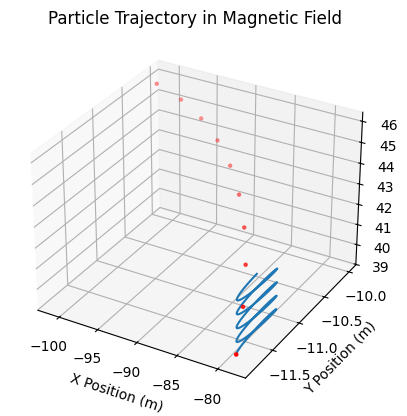

In [186]:
q = 1.0   # charge in e
#mass = 0.105 # GeV/c² for muon (you can replace with realistic values)
B = np.array([0.0, 0.0, 2.0])  # Tesla, uniform field in z-direction
h = 0.01  # Step size in meters

def lorentz_force(p, B):
    # Velocity from momentum (non-relativistic approx)
    v = p / np.linalg.norm(p)
    return q * np.cross(v, B)

def rk4_step(x, p):
    # RK4 integration for position and momentum
    def dp_dt(p): return lorentz_force(p, B)
    def dx_dt(p): return p / np.linalg.norm(p)  # direction of motion

    k1_x = h * dx_dt(p)
    k1_p = h * dp_dt(p)

    k2_x = h * dx_dt(p + 0.5 * k1_p)
    k2_p = h * dp_dt(p + 0.5 * k1_p)

    k3_x = h * dx_dt(p + 0.5 * k2_p)
    k3_p = h * dp_dt(p + 0.5 * k2_p)

    k4_x = h * dx_dt(p + k3_p)
    k4_p = h * dp_dt(p + k3_p)

    x_new = x + (1/6) * (k1_x + 2*k2_x + 2*k3_x + k4_x)
    p_new = p + (1/6) * (k1_p + 2*k2_p + 2*k3_p + k4_p)

    return x_new, p_new

# Example usage
#x = np.array([0.0, 0.0, 0.0])  # initial position
#p = np.array([0.2, 0.1, 0.3])  # initial momentum (GeV/c)
x = np.array(hit_coordinates[0])  # initial position from hit coordinates
# Estimate initial momentum based on the first hit
p = estimate_initial_momentum(hit_coordinates, B=2.0, charge=1)

trajectory = [x]
for i in range(1000):
    x, p = rk4_step(x, p)
    trajectory.append(x)

print(np.array(trajectory)[:, 0], np.array(trajectory)[:, 1],np.array(trajectory)[:, 2])
x, y, z = np.array(trajectory)[:, 0], np.array(trajectory)[:, 1], np.array(trajectory)[:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.scatter(hitx, hity, hitz, color='red', s=5)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_title('Particle Trajectory in Magnetic Field')

plt.show()